In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['jigsaw-unintended-bias-in-toxicity-classification', 'glove-global-vectors-for-word-representation']


In [2]:
df = pd.read_csv('../input/jigsaw-unintended-bias-in-toxicity-classification/train.csv')

In [3]:
SUBTYPES = ['severe_toxicity', 'obscene', 'identity_attack', 'insult', 'threat', 'sexual_explicit']
RATINGS = ['funny', 'wow', 'sad', 'likes', 'disagree']
IDENTITY = ['male', 'female', 'homosexual_gay_or_lesbian', 'christian', 'jewish', 'muslim', 'black', 'white', 'psychiatric_or_mental_illness']

from sklearn.preprocessing import MinMaxScaler
rating_scaler = MinMaxScaler()
rating_scaler.fit(df[RATINGS])

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


MinMaxScaler(copy=True, feature_range=(0, 1))

In [4]:
from typing import List

from collections import OrderedDict
from collections import defaultdict

from keras_preprocessing.text import text_to_word_sequence

class Tokenizer(object):
    def __init__(self,
                 filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
                 lower=True,
                 split=' '):
        self.filters = filters
        self.lower = lower
        self.split = split
        self.word_counts = OrderedDict()
        self.word_docs = defaultdict(int)
        self._embeddings_index = {}
        self._embedding_dims = None
        self.reserved_tokens = ['__UNK__', '__<S>__', '___</S>___']
        self.word_index = dict()
        self.index_word = dict()
        self.sentence_lens = defaultdict(int)

    def num(self):
        return len(self.word_index)

    def load_embeddings(self, filename: str, ndims: int):
        self._embedding_dims = ndims
        with open(filename) as file:
            for line in file:
                values = line.split()
                word = values[0]
                coefs = np.asarray(values[1:], dtype='float32')
                self._embeddings_index[word] = coefs

        print('Found %s word vectors.' % len(self._embeddings_index))

    def _filter(self, word_counts: OrderedDict) -> OrderedDict:
        result = OrderedDict()
        for word, count in word_counts.items():
            if word in self._embeddings_index or count > 10:
                result[word] = count
        return result

    def fit(self, sentences: List[str]) -> None:
        for text in sentences:
            if isinstance(text, list):
                if self.lower:
                    if isinstance(text, list):
                        text = [text_elem.lower() for text_elem in text]
                    else:
                        text = text.lower()
                seq = text
            else:
                seq = text_to_word_sequence(text, self.filters, self.lower, self.split)
            self.sentence_lens[len(seq)] += 1
            for w in seq:
                if w in self.word_counts:
                    self.word_counts[w] += 1
                else:
                    self.word_counts[w] = 1
            for w in set(seq):
                # In how many documents each word occurs
                self.word_docs[w] += 1

        self.word_counts = self._filter(self.word_counts)
        wcounts = list(self.word_counts.items())
        wcounts.sort(key=lambda x: x[1], reverse=True)
        sorted_voc = self.reserved_tokens
        sorted_voc.extend(wc[0] for wc in wcounts)

        self.word_index = dict(
            list(zip(sorted_voc, list(range(1, len(sorted_voc) + 1)))))

        self.index_word = dict((c, w) for w, c in self.word_index.items())

    def make_embedding_matrix(self) -> np.array:
        embedding_matrix = np.zeros(
            (len(self.word_index) + 1, self._embedding_dims))
        for word, i in self.word_index.items():
            embedding_vector = self._embeddings_index.get(word)
            if embedding_vector is not None:
                embedding_matrix[i] = embedding_vector
            else:
                vec = i / np.arange(1, (self._embedding_dims) + 1)
                vec[0::2] = np.sin(vec[0::2])
                vec[1::2] = np.cos(vec[1::2])
                embedding_matrix[i] = vec
        return embedding_matrix

    def generate(self, sentences: List[str], max_size: int) -> np.array:
        X = np.zeros((len(sentences), max_size), dtype=int)
        for i, text in enumerate(sentences):
            seq = text_to_word_sequence(text, self.filters, self.lower, self.split)
            for j, tok in enumerate(seq):
                if j == max_size:
                    break
                idx = self.word_index.get(tok, 1)
                X[i, j] = idx

        return X


In [5]:
GLOVE_DIR='../input/glove-global-vectors-for-word-representation'
EMBEDDING_DIM=100

tokens = Tokenizer()
tokens.load_embeddings(os.path.join(GLOVE_DIR, 'glove.6B.100d.txt'), EMBEDDING_DIM)
tokens.fit(df['comment_text'])
embedding_matrix = tokens.make_embedding_matrix()

Found 400000 word vectors.


In [6]:
from sklearn import metrics
import tensorflow as tf

def auc_calc(y_true, y_pred):
    y_true = y_true >= .5
    if np.unique(y_true).size > 1:
        return metrics.roc_auc_score(y_true, y_pred)
    return 0.0

def auc(y_true, y_pred):
    return tf.py_func(auc_calc, (y_true, y_pred), tf.double)

def power_mean(series, p):
    if len(series) == 0:
        return 0.0
    total = sum(np.power(series, p))
    return np.power(total / len(series), 1 / p)

def bias_auc_fn(y_true, y_pred, m_true, m_pred):
    POWER = -5

    scores_sgroup = []
    scores_bpsn = []
    scores_bnsp = []

    for i in range(len(IDENTITY)):
        toxic = np.where(y_true >= 0.5)[0]
        comp_toxic = set(range(y_true.shape[0])) - set(toxic)
        sgroup = np.where(m_true[:, i] > 0.0)[0]
        comp_sgroup = set(range(y_true.shape[0])) - set(sgroup)

        if len(sgroup) == 0:
            continue

        labels = y_true[sgroup] >= .5
        if np.unique(labels).size > 1:
            m = metrics.roc_auc_score(labels, y_pred[sgroup])
            if m > 0:
                scores_sgroup.append(m)
        
        bpsn = list( (comp_toxic & set(sgroup)) | (set(toxic) & comp_sgroup) )
        labels = y_true[bpsn] >= .5
        if np.unique(labels).size > 1:
            m = metrics.roc_auc_score(labels, y_pred[bpsn])
            if m > 0:
                scores_bpsn.append(m)

        bnsp = list( (set(toxic) & set(sgroup)) | (comp_toxic & comp_sgroup) )
        labels = y_true[bnsp] >= .5
        if np.unique(labels).size > 1:
            m = metrics.roc_auc_score(labels, y_pred[bnsp])
            if m > 0:
                scores_bnsp.append(m)

    bias_score = np.average([
        power_mean(scores_sgroup, POWER),
        power_mean(scores_bpsn, POWER),
        power_mean(scores_bnsp, POWER)
    ])
    return bias_score 

class BiasAuc(object):
    def __init__(self, model):
        self.model = model

    @property
    def __name__(self):
        return "bias_auc"

    def __call__(self, y_true, y_pred):
        return tf.py_func(bias_auc_fn, (model.targets[0], model.outputs[0], y_true, y_pred), tf.double)

In [7]:
from tensorflow import keras

class Generator(keras.utils.Sequence):
    def __init__(self, df: pd.DataFrame, tokens: Tokenizer, max_sequence: int, batch_size=1024, gen_labels=True):
        self.dataframe = df
        self.tokenizer = tokens
        self.max_sequence = max_sequence
        self.batch_size = batch_size
        self.gen_labels = gen_labels

    def __len__(self):
        return int((self.dataframe.shape[0] - 1) / self.batch_size) + 1

    def __getitem__(self, index):
        start = index * self.batch_size
        end = min(start + self.batch_size, self.dataframe.shape[0])
        texts = self.dataframe['comment_text'].iloc[start:end]
        X = self.tokenizer.generate(texts, self.max_sequence)
        if not self.gen_labels:
            return X
        y_labels = [
            self.dataframe['target'].iloc[start:end].values,
            np.nan_to_num(self.dataframe[IDENTITY].iloc[start:end].values),
            np.nan_to_num(self.dataframe[SUBTYPES].iloc[start:end].values),
            rating_scaler.transform(np.nan_to_num(self.dataframe[RATINGS].iloc[start:end].values)),
        ]
        return X, y_labels

In [8]:
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model

MAX_SEQUENCE = 200

embedding = Embedding(embedding_matrix.shape[0], embedding_matrix.shape[1], weights=[embedding_matrix],
                      trainable=False, mask_zero=True)

seq = Input(shape=(MAX_SEQUENCE,))
vecs = embedding(seq)
layer1 = GRU(300, reset_after=True, recurrent_activation='sigmoid')(vecs)
sentence_vec = layer1
target = Dense(1, name='target')(sentence_vec)
ident = Dense(len(IDENTITY), name='ident')(sentence_vec)
subtypes = Dense(len(SUBTYPES), name='subtypes')(sentence_vec)
ratings = Dense(len(RATINGS), name='ratings')(sentence_vec)
model = Model(seq, outputs=[target, ident, subtypes, ratings])

m_bias = BiasAuc(model)
model.compile('adam', 'mse', loss_weights={'target': 1.0, 'ident': 0.4, 'subtypes': 0.2, 'ratings': 0.2},
              metrics={'target': auc, 'ident': m_bias})
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, use
    tf.py_function, which takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 200)          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 200, 100)  

In [9]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size=0.1)

In [12]:
history = model.fit(Generator(train, tokens, MAX_SEQUENCE, batch_size=4*1024),
                    validation_data=Generator(test, tokens, MAX_SEQUENCE, batch_size=4*1024), epochs=10)

397/397 [==============================] - 377s 949ms/step - loss: 0.0229 - target_loss: 0.0193 - ident_loss: 0.0065 - subtypes_loss: 0.0049 - ratings_loss: 5.0470e-04 - target_auc: 0.9310 - ident_bias_auc: 0.8634 - val_loss: 0.0216 - val_target_loss: 0.0185 - val_ident_loss: 0.0053 - val_subtypes_loss: 0.0046 - val_ratings_loss: 4.4981e-04 - val_target_auc: 0.9335 - val_ident_bias_auc: 0.8646


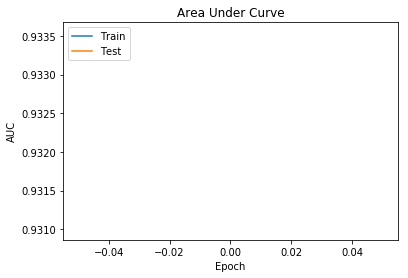

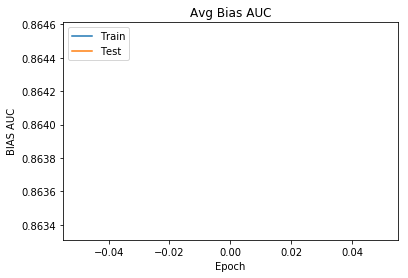

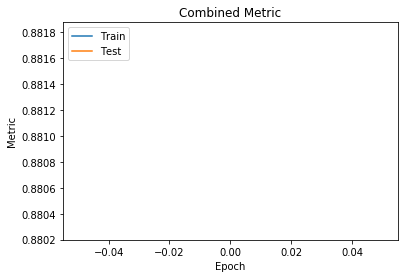

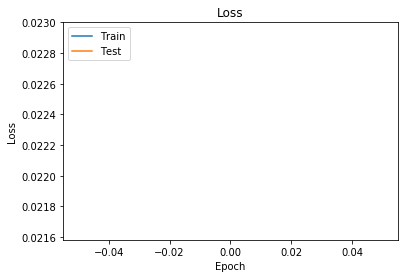

In [17]:
%matplotlib inline

import matplotlib.pyplot as plt

h_train = np.array(history.history['target_auc'])
h_val_train = np.array(history.history['val_target_auc'])

plt.plot(h_train)
plt.plot(h_val_train)
plt.title('Area Under Curve')
plt.ylabel('AUC')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

h_train_bias = np.array(history.history['ident_bias_auc'])
h_val_bias = np.array(history.history['val_ident_bias_auc'])
plt.plot(h_train_bias)
plt.plot(h_val_bias)
plt.title('Avg Bias AUC')
plt.ylabel('BIAS AUC')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

OVERALL_METRIC_FACTOR = 0.25
m_train = OVERALL_METRIC_FACTOR * h_train + (1 - OVERALL_METRIC_FACTOR) * h_train_bias
m_val = OVERALL_METRIC_FACTOR * h_val_train + (1 - OVERALL_METRIC_FACTOR) * h_val_bias

plt.plot(m_train)
plt.plot(m_val)
plt.title('Combined Metric')
plt.ylabel('Metric')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


In [ ]:
df_test = pd.read_csv('../input/jigsaw-unintended-bias-in-toxicity-classification/test.csv')
outs = model.predict_generator(Generator(df_test, tokens, MAX_SEQUENCE, gen_labels=False))

sub = pd.read_csv('../input/jigsaw-unintended-bias-in-toxicity-classification/sample_submission.csv', index_col='id')
sub['prediction'] = outs[0]
sub.to_csv('submission.csv')